# Bank Customer Churn.

In today's competitive banking landscape, retaining customers is as crucial as acquiring new ones. Customer churn, the phenomenon where customers cease their relationship with a bank, can significantly impact a financial institution's bottom line. This machine learning project aims to develop a predictive model to identify customers at risk of churning, enabling proactive retention strategies.

## **1. Data Preparation.**

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mltable
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve
from imblearn.over_sampling import SMOTE

In [4]:
# Load data
ml_client = MLClient.from_config(credential=DefaultAzureCredential())
data_asset = ml_client.data.get("bank_customer_data_new", version="1")

tbl = mltable.load(f'azureml:/{data_asset.id}')

df = tbl.to_pandas_dataframe()
df.head()

Found the config file in: /config.json


,RowNumber,CustomerId,Surname,First Name,Date of Birth,Gender,Marital Status,Number of Dependents,Occupation,Income,...,Preferred Communication Channel,Credit Score,Credit History Length,Outstanding Loans,Churn Flag,Churn Reason,Churn Date,Balance,NumOfProducts,NumComplaints
0,1,83ef0b54-35f6-4f84-af58-5653ac0c0dc4,Smith,Troy,1987-08-29,Male,Divorced,3,Information systems manager,77710.14,...,Phone,397,24,41959.74,0,None,NaT,211359.05,1,0
1,2,009f115a-e5ca-4cf4-97d6-530140545e4e,Sullivan,Katrina,2000-02-07,Female,Married,1,Charity fundraiser,58209.87,...,Email,665,10,8916.67,0,None,NaT,30624.76,4,1
2,3,66309fd3-5009-44d3-a3f7-1657c869d573,Fuller,Henry,1954-02-03,Female,Single,1,Television production assistant,9794.01,...,Email,715,21,43270.54,0,None,NaT,111956.61,2,6
3,4,b02a30df-1a5f-4087-8075-2a35432da641,Young,Antonio,1991-01-15,Female,Divorced,5,Agricultural engineer,15088.98,...,Phone,747,17,17887.65,0,None,NaT,201187.61,1,0
4,5,0d932e5b-bb3a-4104-8c83-f84270f7f2ea,Andersen,John,1992-04-08,Female,Divorced,2,"Teacher, early years/pre",60726.56,...,Email,549,25,32686.84,0,None,NaT,60391.24,5,6


In [5]:
# Check for missing values
print(df.isnull().sum())




RowNumber                               0
CustomerId                              0
Surname                                 0
First Name                              0
Date of Birth                           0
Gender                                  0
Marital Status                          0
Number of Dependents                    0
Occupation                              0
Income                                  0
Education Level                         0
Address                                 0
Contact Information                     0
Customer Tenure                         0
Customer Segment                        0
Preferred Communication Channel         0
Credit Score                            0
Credit History Length                   0
Outstanding Loans                       0
Churn Flag                              0
Churn Reason                       101546
Churn Date                         101546
Balance                                 0
NumOfProducts                     

In [6]:
# Check data types
print(df.dtypes)

RowNumber                                   int64
CustomerId                                 object
Surname                                    object
First Name                                 object
Date of Birth                      datetime64[ns]
Gender                                     object
Marital Status                             object
Number of Dependents                        int64
Occupation                                 object
Income                                    float64
Education Level                            object
Address                                    object
Contact Information                        object
Customer Tenure                             int64
Customer Segment                           object
Preferred Communication Channel            object
Credit Score                                int64
Credit History Length                       int64
Outstanding Loans                         float64
Churn Flag                                  int64


In [8]:
# Summary statistics
df.describe()


,RowNumber,Number of Dependents,Income,Customer Tenure,Credit Score,Credit History Length,Outstanding Loans,Churn Flag,Balance,NumOfProducts,NumComplaints
count,115640.000000,115640.000000,115640.000000,115640.000000,115640.000000,115640.000000,115640.000000,115640.000000,115640.000000,115640.000000,115640.000000
mean,57820.500000,2.502923,52641.363046,15.490591,574.299775,15.546602,25502.731792,0.121878,124639.209748,2.999274,4.991724
std,33382.536902,1.707249,27429.756390,8.654217,159.067499,8.654630,14127.859827,0.327147,72210.476638,1.411361,3.159283
min,1.000000,0.000000,5000.960000,1.000000,300.000000,1.000000,1000.430000,0.000000,1.060000,1.000000,0.000000
25%,28910.750000,1.000000,28857.070000,8.000000,436.000000,8.000000,13226.060000,0.000000,61991.915000,2.000000,2.000000
50%,57820.500000,3.000000,52658.110000,15.000000,574.000000,16.000000,25505.285000,0.000000,124505.890000,3.000000,5.000000
75%,86730.250000,4.000000,76364.157500,23.000000,712.000000,23.000000,37742.250000,0.000000,187122.922500,4.000000,8.000000
max,115640.000000,5.000000,99999.510000,30.000000,850.000000,30.000000,49999.690000,1.000000,249998.910000,5.000000,10.000000


## **3. Exploratory Data Analysis.**

#### **a) Distribution of Target Variable.**

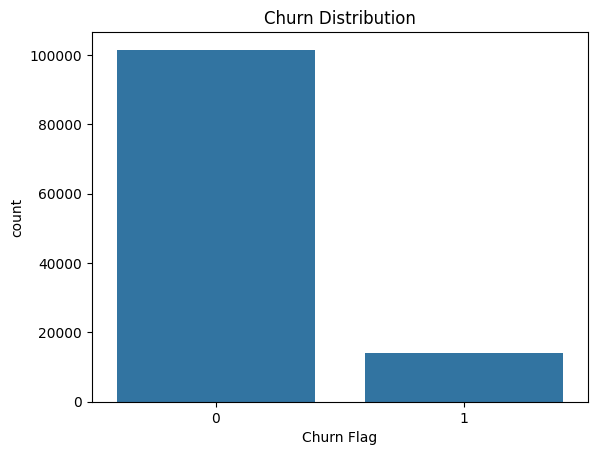

In [9]:
# Visualize the target variable
sns.countplot(x='Churn Flag', data=df)
plt.title('Churn Distribution')
plt.show()

Insight - There is a huge imbalance between the two classes.

`Solution` 
        
    1. Class Weights in the Model 1

    2. Undersample the Majority Class in Model 2

#### **b) Average balance by churn status.**

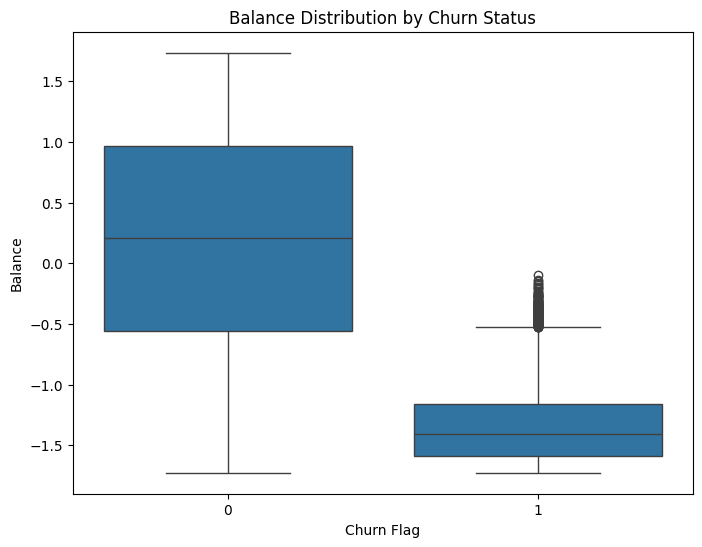

In [32]:
# Average balance by churn status
plt.figure(figsize=(8, 6))
sns.boxplot(x='Churn Flag', y='Balance', data=df)
plt.title('Balance Distribution by Churn Status')
plt.show()

#### **c) Correlation among features.**

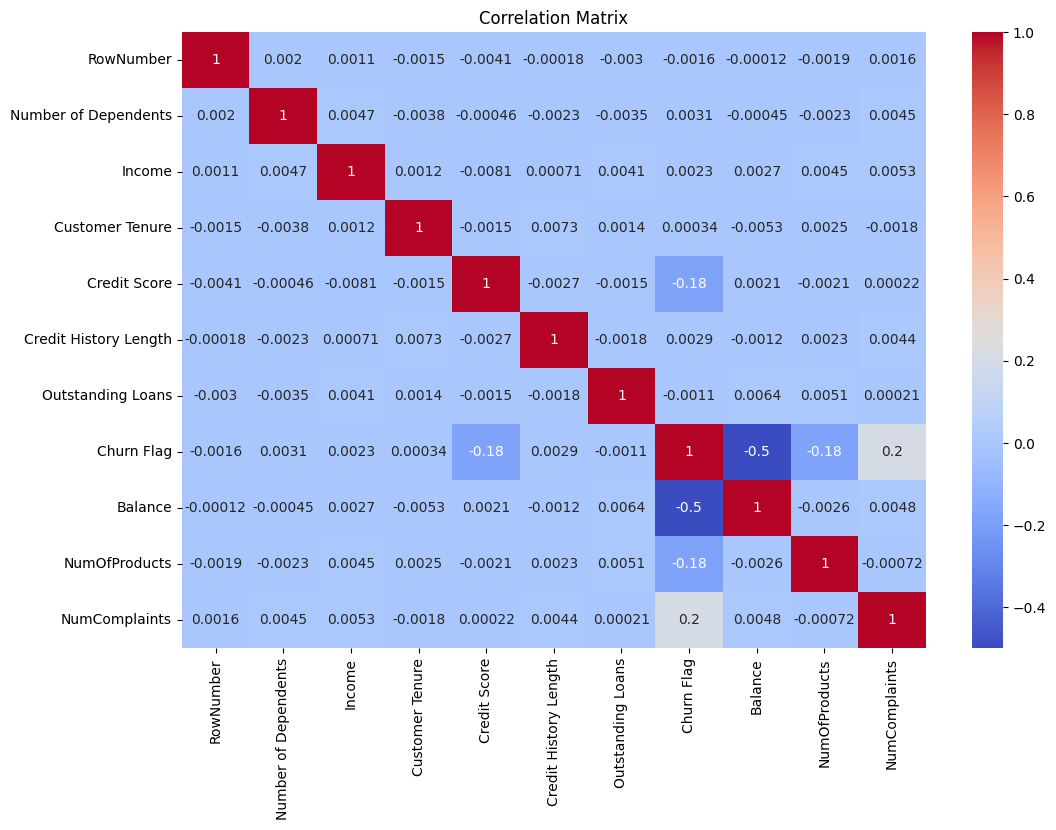

In [10]:
# Correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

#### **d) Income Distribution.**

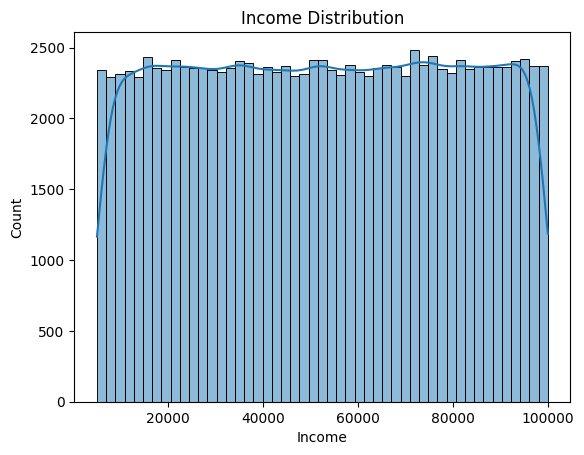

In [11]:
# Distribution of income
sns.histplot(df['Income'], kde=True)
plt.title('Income Distribution')
plt.show()

## Errors and inconsistencies in the data.

1. Missing values 

- `Solution` - Identify the percentage and either fill with (mean, mode) or drop them.

2. Find all outliers in the dataset.

- `Solution` - Remove them, imputation.

3. Class Imbalance

- `Solution` - Upsampling 

## **4. Feature Engineering & Model Building**

In [12]:
# Drop columns that are not useful for modeling
df = df.drop(columns=['RowNumber', 'CustomerId', 'Surname', 'First Name', 'Date of Birth', 'Address', 'Contact Information', 'Churn Reason', 'Churn Date'])


In [13]:
# Convert 'Gender' and 'Marital Status' to numeric using one-hot encoding or label encoding
df = pd.get_dummies(df, columns=['Gender', 'Marital Status', 'Occupation', 'Education Level', 'Customer Segment', 'Preferred Communication Channel'], drop_first=True)


In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['Income', 'Credit Score', 'Outstanding Loans', 'Balance']] = scaler.fit_transform(df[['Income', 'Credit Score', 'Outstanding Loans', 'Balance']])

In [15]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Churn Flag'])
y = df['Churn Flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Initialize the model
model = LogisticRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.9968292401706446
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     30419
           1       0.99      0.99      0.99      4273

    accuracy                           1.00     34692
   macro avg       0.99      0.99      0.99     34692
weighted avg       1.00      1.00      1.00     34692



/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## **5. Saving the model.** 

In [20]:
# Save the model
import joblib

# Assuming 'model' is your trained model
joblib.dump(model, 'model.pkl')

['model.pkl']

In [21]:
from azureml.core import Workspace, Experiment, Environment
from azureml.core.model import Model

# Connect to workspace
ws = Workspace.from_config()

# Create an experiment
experiment = Experiment(ws, 'churn-prediction')

# Log the experiment
run = experiment.start_logging()

In [22]:
from azureml.core import Model

# Register the model
model = Model.register(ws, model_name='churn_model', model_path='model.pkl')

Registering model churn_model


### **6. Deploy model to an endpoint.**

In [24]:
from azureml.core.webservice import AciWebservice, Webservice
from azureml.core.model import InferenceConfig

# Define the environment
inference_env = Environment.get(workspace=ws, name='AzureML-sklearn-0.24-ubuntu18.04-py37-cpu')

# Create inference configuration
inference_config = InferenceConfig(entry_script="score.py", environment=inference_env)

# Define deployment configuration
aci_config = AciWebservice.deploy_configuration(cpu_cores=1, memory_gb=1)

# Deploy the model
service = Model.deploy(workspace=ws,
                       name='churn-prediction-service',
                       models=[model],
                       inference_config=inference_config,
                       deployment_config=aci_config)

service.wait_for_deployment(show_output=True)

print(f"Scoring URI: {service.scoring_uri}")


/tmp/ipykernel_30393/2457430256.py:14: FutureWarning: azureml.core.model:
To leverage new model deployment capabilities, AzureML recommends using CLI/SDK v2 to deploy models as online endpoint, 
please refer to respective documentations 
https://docs.microsoft.com/azure/machine-learning/how-to-deploy-managed-online-endpoints /
https://docs.microsoft.com/azure/machine-learning/how-to-attach-kubernetes-anywhere 
For more information on migration, see https://aka.ms/acimoemigration 
To disable CLI/SDK v1 deprecation warning set AZUREML_LOG_DEPRECATION_WARNING_ENABLED to 'False'
  service = Model.deploy(workspace=ws,


Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2024-09-17 14:18:37+00:00 Creating Container Registry if not exists..
2024-09-17 14:28:38+00:00 Registering the environment.
2024-09-17 14:28:41+00:00 Use the existing image..
2024-09-17 14:28:47+00:00 Generating deployment configuration..
2024-09-17 14:28:54+00:00 Submitting deployment to compute..
2024-09-17 14:29:07+00:00 Checking the status of deployment churn-prediction-service..
2024-09-17 14:31:02+00:00 Checking the status of inference endpoint churn-prediction-service.
Succeeded
ACI service creation operation finished, operation "Succeeded"
Scoring URI: http://12d5c3fa-c3bc-4149-8d18-0e8014d2fb48.southafricanorth.azurecontainer.io/score
